<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_3/notebooks/DeepONet_train_HeatDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More advanced deep operator learning tutorial

This tutorial is taken from the [deepxde framework](https://github.com/lululxvi/deepxde) using their [deepONet](https://github.com/lululxvi/deeponet) implementation and trains a deepONet on heat diffusion in 2d.

In [ ]:
#importing from deepxde-0.11.2 https://github.com/lululxvi/deepxde
import sys
sys.path.insert(1, "../deepxde-0.11.2/")
import deepxde_112 as dde

#importing from deeponet-1.0.0 https://github.com/lululxvi/deeponet
sys.path.insert(1, "../deeponet-1.0.0/")
sys.path.insert(1, "../deeponet-1.0.0/src/")

from src.deeponet_pde import lt_system,ode_system,dr_system,cvc_system,advd_system,run
from src.deeponet_pde import test_u_lt,test_u_ode,test_u_dr,test_u_cvc,test_u_advd

from src.spaces import FinitePowerSeries, FiniteChebyshev, GRF
from src.system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem
from src.utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

#other imports
import itertools

import numpy as np
import tensorflow as tf
from scipy.signal import sawtooth
from scipy.stats import norm


import matplotlib.pyplot as plt
from matplotlib import cm


# Warnings as Result of using outdated tensorflow (don't apper to be fatal)
# disabling warnings at own risk:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\ten

Using TensorFlow 1 backend.




# Training a DeepONet on a System

This Demo relies heavily on the DeepONet implementations offered by luluxvi (https://github.com/lululxvi).

We apply the DeepONet Network to a specific Operator/Equation System:

    a) we select a specific architecture and the Network's dimensions

    b) we will generate input Data using e.g. Gaussian Random Fields

    c) for the input functions we will numerically calculate respective Solutions
    
    d) On this labelled Dataset we train the DeepONet and evaluate the Results

## 1. Run DeepONet

#### 1.1. Specify System

We will use this system:
The Diffusion-Reaction Systeam with diffusion constant k=0 is equivalent to Heat-Diffusion.

In [ ]:
def dr_system(T, npoints_output):
    """Diffusion-reaction"""
    D = 0.01
    k = 0.0
    Nt = 100
    return DRSystem(D, k, T, Nt, npoints_output)

In [ ]:
# Problems:
# - "lt": Legendre transform
# - "ode": Antiderivative, Nonlinear ODE, Gravity pendulum
# - "dr": Diffusion-reaction
# - "cvc": Advection
# - "advd": Advection-diffusion

problem = "HD"
T = 1
npoints_output = 100

system = dr_system(T, npoints_output)

#### 1.2 Define Input Function Space for Training

In [ ]:
# Function space
# space = FinitePowerSeries(N=100, M=1)
# space = FiniteChebyshev(N=20, M=1)
# space = GRF(2, length_scale=0.2, N=2000, interp="cubic")  # "lt"
space = GRF(1, length_scale=0.15, N=1000, interp="cubic")
# space = GRF(T, length_scale=0.2, N=1000 * T, interp="cubic")

#### 1.3 Define Neural Net

We define the Net Architecture with 2 Layers of size 40, for both the Branch and Trunk Net - using a Unstacked Architecture.

In [ ]:
# Hyperparameters
m = 100             # Nr. of sensors
num_train = 30000   # Nr. train samples
num_test =  30000   # Nr. test samples (originally 100k)
lr = 0.001
epochs = 30000      # originally 50k

# Network
nn = "opnn"
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 2

net = dde.maps.OpNN(
    [m, 40, 40],
    [dim_x, 40, 40],
    activation,
    initializer,
    use_bias=True,
    stacked=False,
)

#### 1.5 Generate Input Data (Gaussian Random Field)

In [ ]:
X_train, y_train = system.gen_operator_data(space, m, num_train)
X_test, y_test = system.gen_operator_data(space, m, num_test)

Generating operator data...
'gen_operator_data' took 269.147935 s

Generating operator data...
'gen_operator_data' took 270.356577 s



Optional: save or load data to save time

(The Numerical Calculations for generating Training Data can be a time-consuming step)

In [ ]:
np.savez_compressed("DR_system_data/train_30k_l015.npz", X_train0=X_train[0], X_train1=X_train[1], y_train=y_train)
np.savez_compressed("DR_system_data/test_30k_l015.npz", X_test0=X_test[0], X_test1=X_test[1], y_test=y_test)

In [ ]:
d = np.load("DR_system_data/train_30k_l015.npz")
X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
d = np.load("DR_system_data/test_30k_l015.npz")
X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

In [ ]:
# loading data into nn-Format

X_test_trim = trim_to_65535(X_test)[0]
y_test_trim = trim_to_65535(y_test)[0]

data = dde.data.OpDataSet(
    X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim
)


#### 1.6 Train Model and Evaluate Results

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1000
)

Compiling model...
Building operator neural network...
'build' took 0.095423 s

'compile' took 0.235491 s



Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [2.23e-01]    [2.25e-01]    [2.19e-01]    
1000      [1.83e-03]    [1.90e-03]    [1.84e-03]    
2000      [7.31e-04]    [7.48e-04]    [7.26e-04]    
3000      [5.02e-04]    [5.11e-04]    [4.99e-04]    
4000      [3.72e-04]    [3.77e-04]    [3.67e-04]    
5000      [2.88e-04]    [2.92e-04]    [2.84e-04]    
6000      [2.80e-04]    [2.81e-04]    [2.75e-04]    
7000      [1.84e-04]    [1.85e-04]    [1.81e-04]    
8000      [1.65e-04]    [1.66e-04]    [1.62e-04]    
9000      [1.48e-04]    [1.49e-04]    [1.45e-04]    
10000     [1.95e-04]    [2.03e-04]    [1.96e-04]    
11000     [1.15e-04]    [1.17e-04]    [1.14e-04]    
12000     [1.07e-04]    [1.08e-04]    [1.05e-04]    
13000     [1.79e-04]    [1.83e-04]    [1.79e-04]    
14000     [9.46e-05]    [9.63e-05]    [9.33e-05]    
15000     [1.32e-04]    [1.38e-04]    [1.34e-04]    
16000     [9.49e-05]    [9.73e-05]    [9.46e-05]    
1

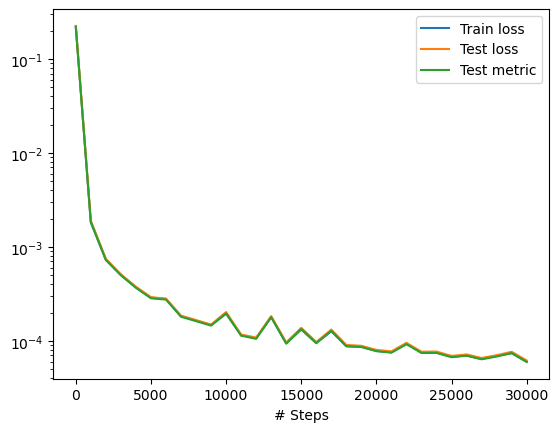

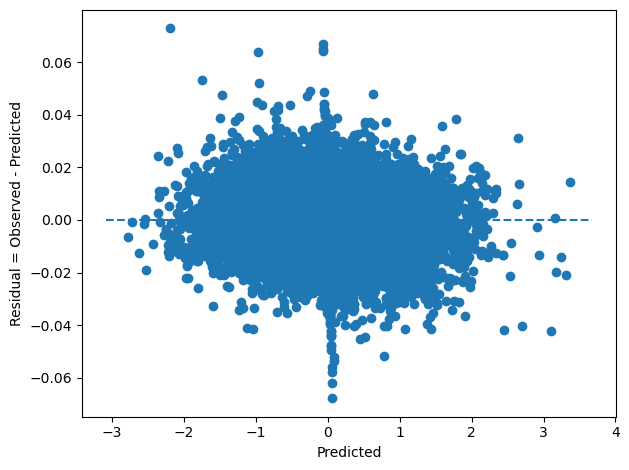

Restoring model from model/model.ckpt-30000 ...

Test MSE: 6.075212384739477e-05
Test MSE w/o outliers: 5.87573968671957e-05



In [ ]:
losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])
print("# Parameters:", np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)
safe_test(model, data, X_test, y_test)

Saving or loading a saved Model:

In [ ]:
# Optional: save model
model.save('./Model Backups/DeepONet_checkpoint_'+problem+"_23_07_15_l_015",verbose=1)

Epoch 30000: saving model to ./Model Backups/DeepONet_checkpoint_HD_23_07_15_l_015-30000 ...



In [ ]:
# Optional: load model
model.restore('./Model Backups/DeepONet_checkpoint_'+problem+"_23_07_15_l_015"+"-30000",verbose=1)

Restoring model from ./Model Backups/DeepONet_checkpoint_HD_23_07_15_l_015-30000 ...



In [ ]:
#Quick test

def test_sys(problem,model,data,system,T,m,space,nn):

    tests = [
        (lambda x: x, "x.dat"),
        (lambda x: np.sin(np.pi * x), "sinx.dat"),
        (lambda x: np.sin(2 * np.pi * x), "sin2x.dat"),
        (lambda x: x * np.sin(2 * np.pi * x), "xsin2x.dat"),
    ]

    for u, fname in tests:
        test_u_dr(nn, system, T, m, model, data, u, fname)

test_sys(problem,model,data,system,T,m,space,nn)

## 2. Visualize Function of the trained DeepONet

In [ ]:
def eval_model_DR(system, model, func, sim = True):
    """Evaluate Diffusion-reaction"""
    # comuputes both numerical and NN solution
    sensors = np.linspace(0, 1, num=m)
    sensor_value = func(sensors)
    if sim:
        s = system.eval_s(sensor_value)
        y_test = s.reshape([m * system.Nt, 1])
    else:
        y_test = None
    xt = np.array(list(itertools.product(range(m), range(system.Nt))))
    xt = xt * [1 / (m - 1), T / (system.Nt - 1)]
    X_test = [np.tile(sensor_value, (m * system.Nt, 1)), xt]
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    return sensors,sensor_value,y_test,y_pred

In [ ]:
def plot_surface(ax,x,y,z,title,colorbar=False,colmap=cm.coolwarm):
    """Plot surface plot of z(x,y)"""
    im = ax.plot_surface(x,y,z, cmap=colmap)
    ax.set_title(title,fontsize=16)
    ax.set_ylabel("t")
    ax.set_xlabel("x")
    ax.set_zlabel("s(x,t)")
    #ax.set_xticks([])
    ax.set_zlim([-1,1])
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    ax.set_zticks([-1,0,1])
    ax.view_init(elev=20, azim=-70)

In [ ]:
# Testing Functions
width=0.3


tests = [
    #(lambda x: x-x+1,"1"),
    (lambda x: x, "x"),
    #(lambda x: np.sin(np.pi * x), "sin(x)"),
    (lambda x: np.sin(2 * np.pi * x), "sin(2x)"),
    #(lambda x: x * np.sin(2 * np.pi * x), "x sin(2x)"),
    #(lambda x: np.heaviside(x-0.5,1)-0.5, "step(x-0.5)"),
    (lambda x: norm(loc=0.5,scale=0.05).pdf(x)*0.3, "normal(x), std=0.05"),
    (lambda x: 2*x - 2*x // 1-0, "sawtooth(2x)"),
    (lambda x: norm(loc=0.25,scale=0.1).pdf(x)*0.23 + norm(loc=0.75,scale=0.1).pdf(x)*0.23,"Double Gaussian"),
    (lambda x: np.heaviside(x-(0.5-width/2),1) * np.heaviside(-(x-(0.5+width/2)),1),"Square Wave"),
]

<Figure size 640x480 with 0 Axes>

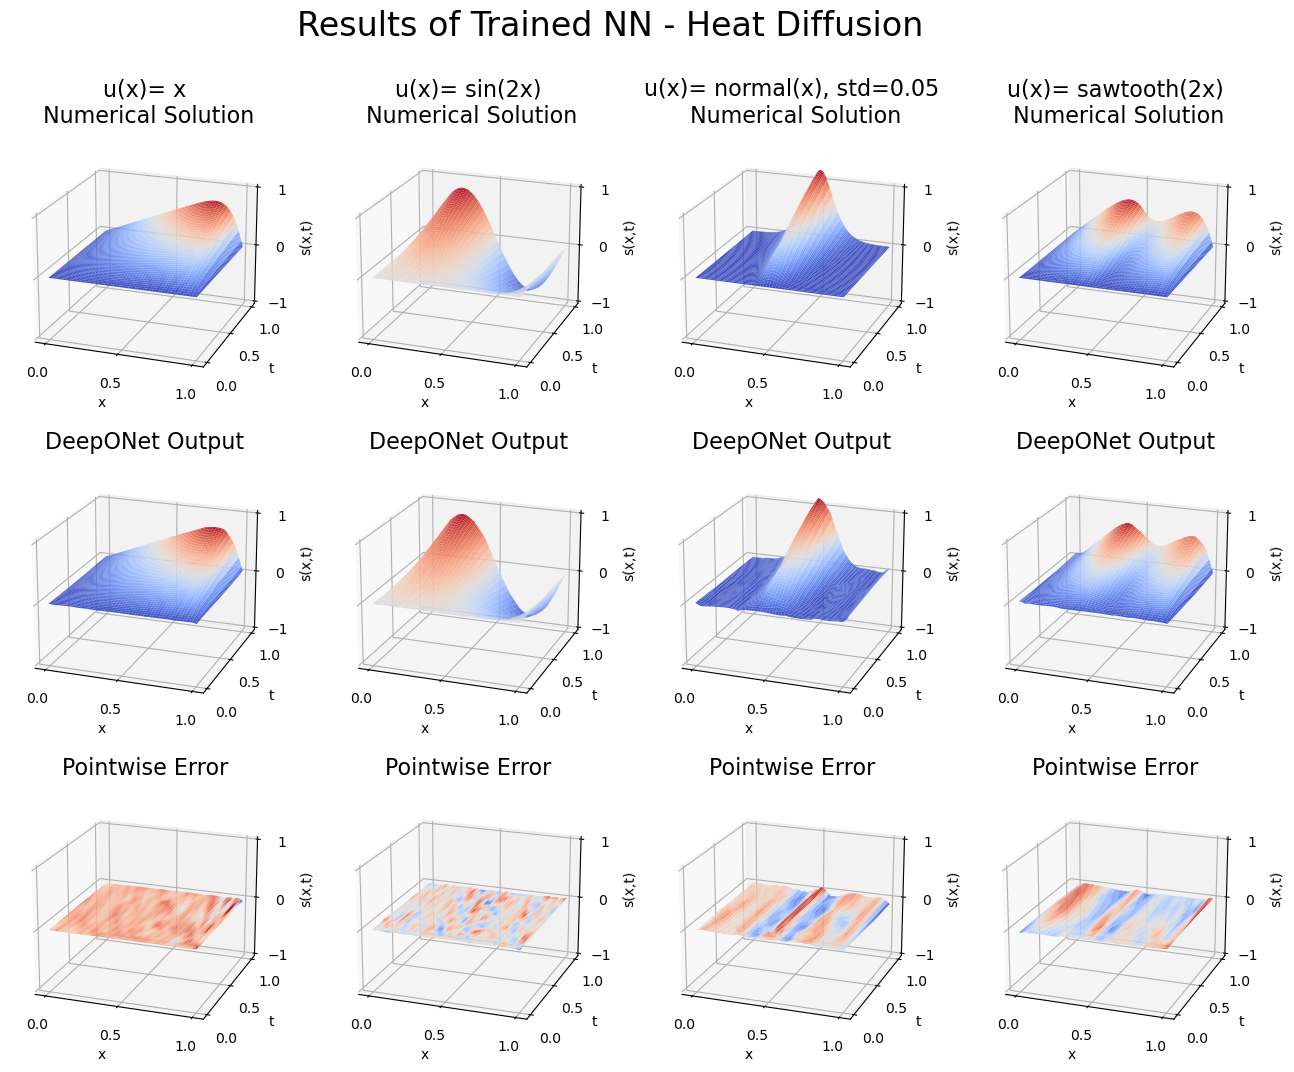

In [ ]:
# Grid of Surface Plots
N=4

fig = plt.figure(1)
fig,axes =plt.subplots(3,N,figsize =(16,12),subplot_kw={"projection": "3d"})
axes =np.transpose(axes)
ax_row=axes[0]

for i,(ax_col,(func,fname)) in enumerate(zip(axes,tests)):
    x_vals,U_xvals,y_num,y_pred = eval_model_DR(system, model, func)

    x,y = np.meshgrid(x_vals,x_vals)
    title = "u(x)= "+fname+"\n Numerical Solution"
    z = np.transpose(y_num.reshape([m,system.Nt]))
    plot_surface(ax_col[0],x,y,z,title)

    title = "DeepONet Output"
    z = np.transpose(y_pred.reshape([m,system.Nt]))
    plot_surface(ax_col[1],x,y,z,title)

    title = "Pointwise Error"
    z = np.transpose((y_num.reshape([m,system.Nt])-y_pred.reshape([m,system.Nt])))
    plot_surface(ax_col[2],x,y,z,title)

fig.suptitle("Results of Trained NN - Heat Diffusion",fontsize=24)
#plt.tight_layout()
plt.savefig("plots/HDiffusion Results 3D.png",dpi=300)
plt.show()

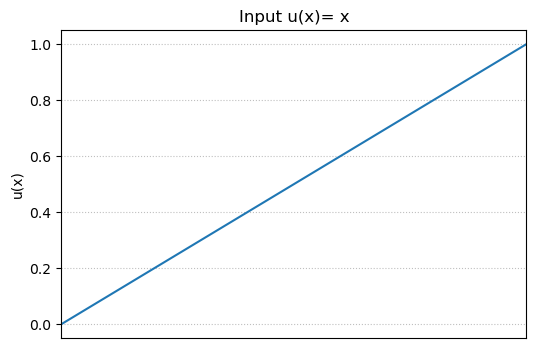

Max Error:  0.03683452680706978  Avg Error:  0.0020602221734076294


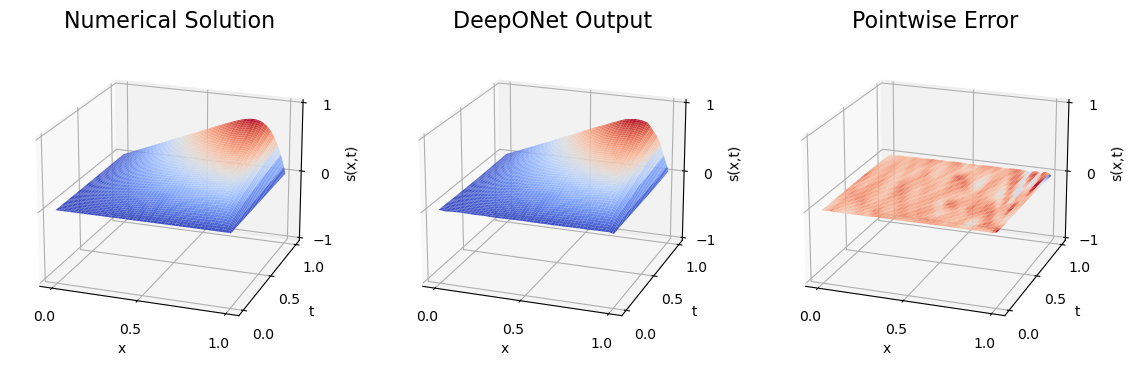

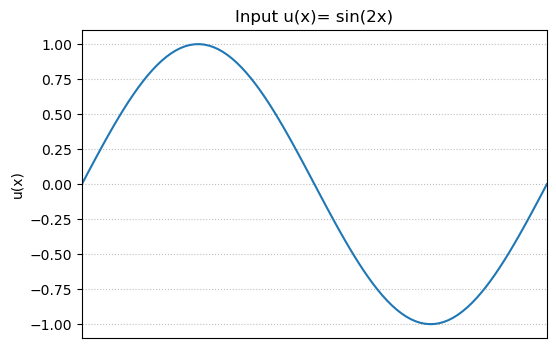

Max Error:  0.019565235823392868  Avg Error:  0.003768589484785663


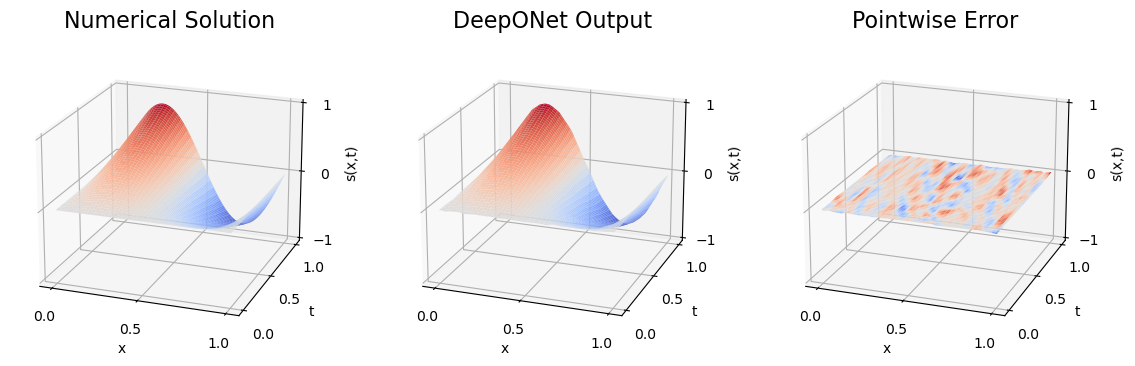

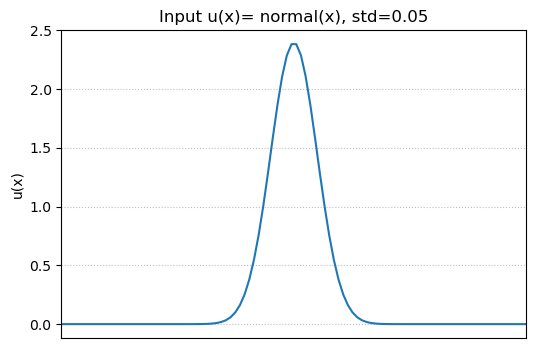

Max Error:  0.08685571700334549  Avg Error:  0.01967051368924839


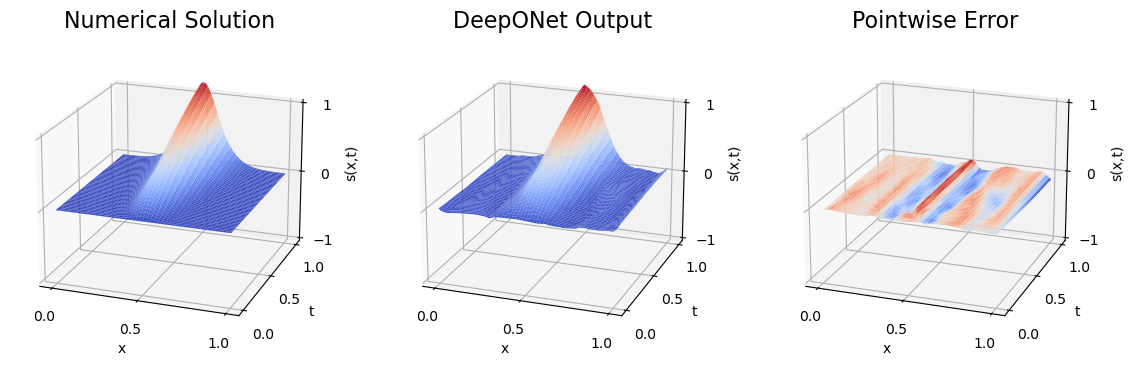

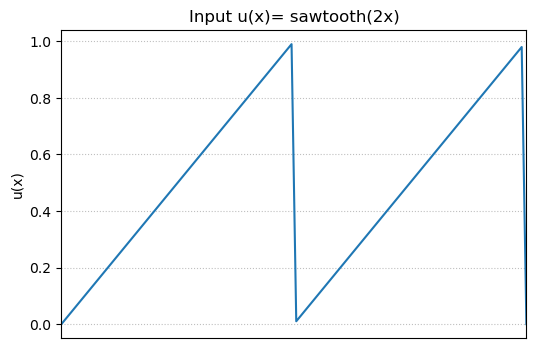

Max Error:  0.06994321197271347  Avg Error:  0.018101027055311532


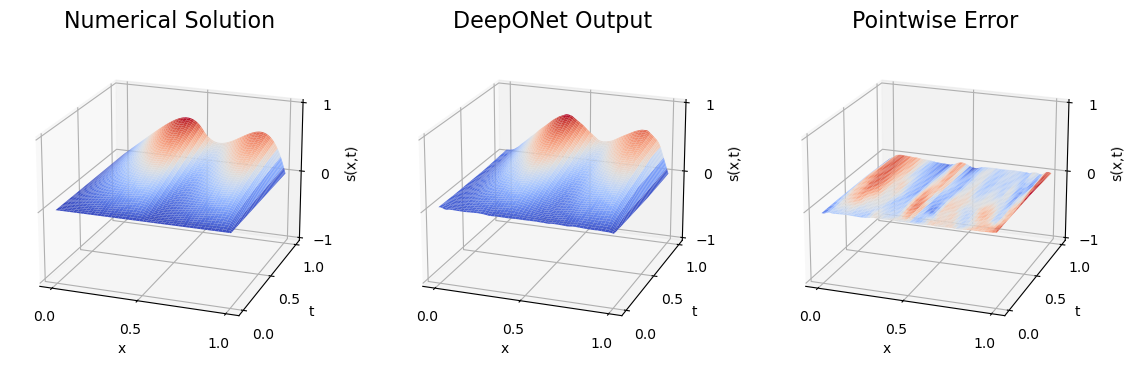

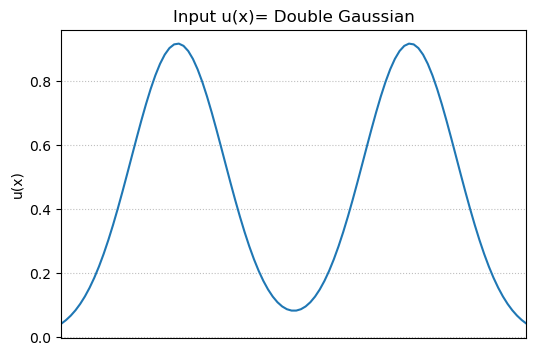

Max Error:  0.01949458196759224  Avg Error:  0.0033175556996117806


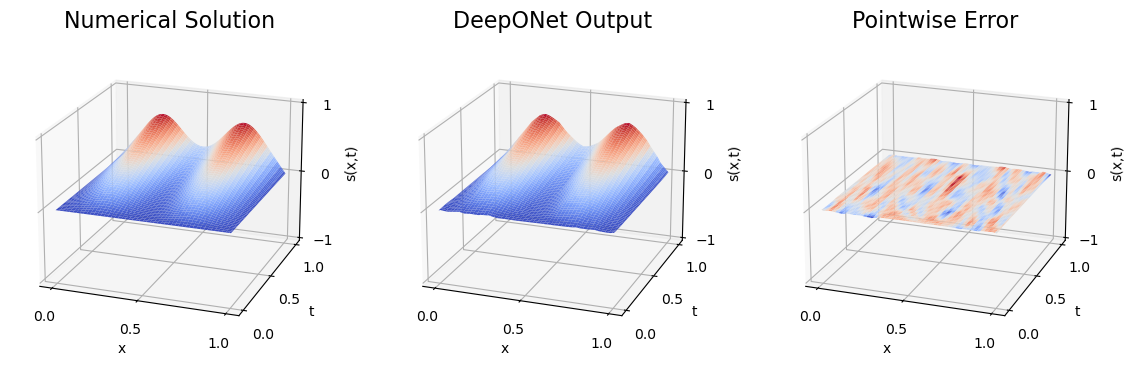

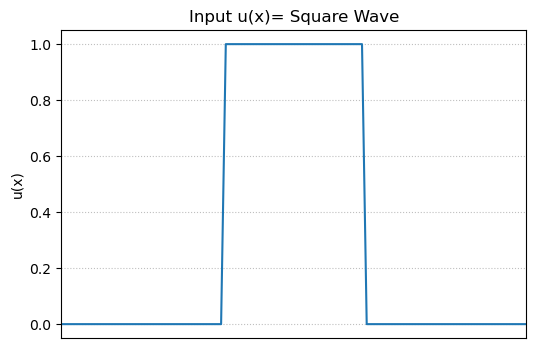

Max Error:  0.08953753691167082  Avg Error:  0.028303160287099467


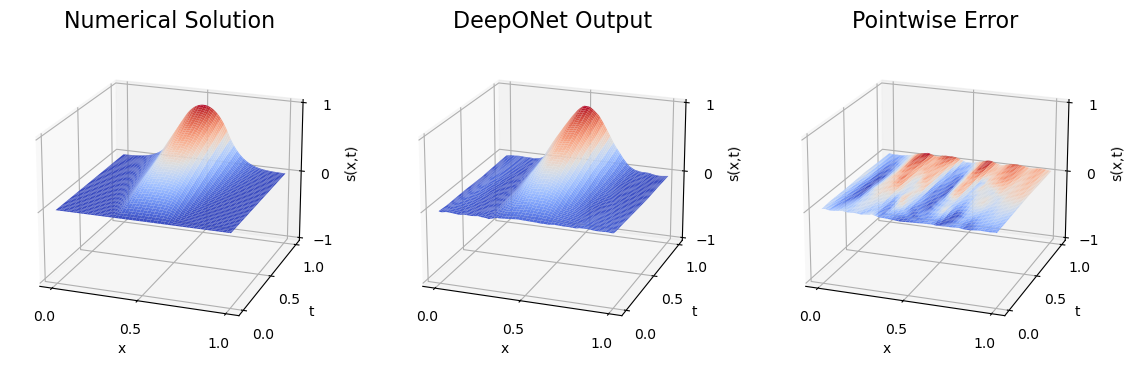

In [ ]:
for func,fname in tests:

    x_vals,U_xvals,y_num,y_pred = eval_model_DR(system, model, func)

    fig,ax = plt.subplots(1,1,figsize =(6,4))

    ax.plot(x_vals,U_xvals, linestyle='-',label="Input Function")
    ax.set_xlim([0,1])
    ax.set_xticks([])
    ax.set_ylabel("u(x)")
    #if (i==N-1): ax_col[0].legend()
    ax.set_title("Input u(x)= "+fname)
    ax.yaxis.grid(True, linestyle=':', which='major', color='grey', alpha=0.5)
    plt.savefig("plots/HDiffusion Input "+fname+".png",dpi=300)
    plt.show()

    fig,axs = plt.subplots(1,3,figsize =(14,6),subplot_kw={"projection": "3d"})

    x,y = np.meshgrid(x_vals,x_vals)

    title = "Numerical Solution"
    z = np.transpose(y_num.reshape([m,system.Nt]))
    plot_surface(axs[0],x,y,z,title)

    title = "DeepONet Output"
    z = np.transpose(y_pred.reshape([m,system.Nt]))
    plot_surface(axs[1],x,y,z,title)

    title = "Pointwise Error"
    z = np.transpose((y_num.reshape([m,system.Nt])-y_pred.reshape([m,system.Nt])))
    plot_surface(axs[2],x,y,z,title)
    print("Max Error: ",np.max(np.abs(z))," Avg Error: ",np.mean(np.abs(z)))

    #plt.tight_layout()
    plt.savefig("plots/HDiffusion Results 3D "+fname+".png",dpi=300)
    plt.show()

Demonstration: generating output for a selected Function u(x):

The functions used in this Visualization are not in the space of functions used for training the DeepONet and yet the pretictions seem to be good.

## 3. Runtime Comparison

Comparing the Runtime of Numerical simulation vs. Inference using out treined DeepONet.

In [ ]:
import time
from time import perf_counter_ns as pc

In [ ]:
def runtime_NNinfer_DR(system, model, iters=1000, weighed=True):
    """Evaluate Diffusion-reaction"""
    # 1. comuputes NN solution and returns runtime
    # 2. computes numerical solution and returns runtime
    #  evaluates all points on 100x100 grid using both methods
    #  returns time taken for evaluations divided by respective number of evaluations (10000)
    #
    #  iters: number of input functions to be averaged over


    # Generating Input Functions from GRF

    # sensor_val_arr, pred_val_arr = system.gen_operator_data(space, m, iters)
    features = space.random(iters)
    sensors = np.linspace(0, 1, num=m)[:, None]
    sensor_values = space.eval_u(features, sensors)

    # Transforming to NN input format:
    # Need to evaluate all points on 100x100 grid
    # input values "sensor_values" are 100 space points -> add 100 time points
    xt = np.array(list(itertools.product(range(m), range(system.Nt))))
    xt = xt * [1 / (m - 1), T / (system.Nt - 1)]
    X_test = [np.tile(sensor_values[0], (m * system.Nt, 1)), xt]
    X_test_arr = [[np.tile(sensor_value, (m * system.Nt, 1)), xt] for sensor_value in sensor_values]

    #1. NN inference
    st = time.perf_counter_ns()
    y_pred = [model.predict(data.transform_inputs(X_test)) for X_test in X_test_arr]
    et = time.perf_counter_ns()

    runtime_nn = (et-st)/(100 *100 * iters) #in ns
    print(f"Runtime DeepONet inference: {runtime_nn:.3f} ns")

    #2. Numerical inference
    st = time.perf_counter_ns()
    s_values = [system.eval_s(sensor_value) for  sensor_value in sensor_values]
    et = time.perf_counter_ns()

    runtime_sim = (et-st)/(100 *100 * iters) #in ns
    if weighed:
        print(f"Runtime Numerical Sim: {runtime_sim:.3f} ns")
    return runtime_nn, runtime_sim

In [ ]:
_=runtime_NNinfer_DR(system, model, iters=1000)

Runtime DeepONet inference: 276.417 ns
Runtime Numerical Sim: 923.082 ns
